importacao de biblioticas


In [2]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
import os
import matplotlib.pyplot as plt



Importacao e limpeza de dados


In [3]:
pla_fib_1 = pd.read_csv(os.path.join('Planilhas', 'NYLON 70_1_2_processado.csv'), encoding='ISO-8859-1', delimiter=';') # RONGO REALMENTE ERROU FISSURA
pla_fib_2 = pd.read_csv(os.path.join('Planilhas', 'NYLON 70_2_2_processado.csv'), encoding='ISO-8859-1', delimiter=';')
pla_fib_3 = pd.read_csv(os.path.join('Planilhas', 'NYLON 70_3_2_processado.csv'), encoding='ISO-8859-1', delimiter=';') #O UNICO Q TEM 4, ENT FDS O 4O
pla_fib_4 = pd.read_csv(os.path.join('Planilhas', 'NYLON 70_4_2_processado.csv'), encoding='ISO-8859-1', delimiter=';')
pla_fib_5 = pd.read_csv(os.path.join('Planilhas', 'NYLON 70_5_2_processado.csv'), encoding='ISO-8859-1', delimiter=';')


pla_norm_1 = pd.read_csv(os.path.join('Planilhas', 'Nylon 2711_1_2_processado.csv'), encoding='ISO-8859-1', delimiter=';')    #EU REAL NN SEI DESSE 
pla_norm_2 = pd.read_csv(os.path.join('Planilhas', 'Nylon 2711_2_2_processado.csv'), encoding='ISO-8859-1', delimiter=';') 
pla_norm_3 = pd.read_csv(os.path.join('Planilhas', 'Nylon 2711_3_2_processado.csv'), encoding='ISO-8859-1', delimiter=';') 
pla_norm_4 = pd.read_csv(os.path.join('Planilhas', 'Nylon 2711_4_2_processado.csv'), encoding='ISO-8859-1', delimiter=';') 
pla_norm_5 = pd.read_csv(os.path.join('Planilhas', 'Nylon 2711_5_2_processado.csv'), encoding='ISO-8859-1', delimiter=';') 


pla_fibs = [pla_fib_1, pla_fib_2, pla_fib_3, pla_fib_4, pla_fib_5]
pla_norms = [pla_norm_1, pla_norm_2, pla_norm_3, pla_norm_4, pla_norm_5]


for i in range(len(pla_fibs)):
    pla_fibs[i] = pla_fibs[i].drop(0)
    pla_fibs[i] = pla_fibs[i].map(lambda x: x.replace(',', '.').replace('"', '') if isinstance(x, str) else x)
    pla_fibs[i] = pla_fibs[i].astype(float)

for i in range(len(pla_norms)):
    pla_norms[i] = pla_norms[i].drop(0)
    pla_norms[i] = pla_norms[i].map(lambda x: x.replace(',', '.').replace('"', '') if isinstance(x, str) else x)
    pla_norms[i] = pla_norms[i].astype(float)



Calculo de E (tks John 3.0)

In [4]:
def calc_modulo_elasticidade_dinamico(df, limite_erro=0.001): #como entrada um DataFrame df e um limite_erro, que determina quão próximo da linearidade os dados devem estar.
    # Filtra valores de tensão positivos
    filtro = df

    # Inicializa variáveis
    n_max = len(filtro)
    modulo_elasticidade = np.nan

    for n in range(2, n_max):  # Começar com 2 pontos
        tensao = filtro['Tensão à flexão (MPa)'].iloc[:n].values      #Para cada iteração do loop, os dados de tensão e deformação são extraídos até o índice n. A deformação é convertida de porcentagem para fração dividindo por 100.
        deformacao = filtro['Deformação (%)'].iloc[:n].values / 100

        # Verifica se todos os valores de deformação ou tensão são iguais
        if np.all(deformacao == deformacao[0]) or np.all(tensao == tensao[0]):
            continue  # Ignora este conjunto e passa para o próximo

        # Realiza a regressão linear
        slope, intercept, r_value, p_value, std_err = linregress(deformacao, tensao) #Realiza a regressão linear nos dados de tensão e deformação. 
                                                                                           #slope representa o coeficiente angular da linha de melhor ajuste, 
                                                                                           # que é o que queremos calcular como o módulo de elasticidade.

        # Prediz a tensão usando a linha de melhor ajuste
        tensao_predita = slope * deformacao + intercept

        # Prediz os valores de tensão com base na linha de melhor ajuste e calcula o Erro Quadrático Médio (EQM) entre os valores reais e os preditos.
        eqm = np.mean((tensao - tensao_predita) ** 2)


#Se o EQM for menor que o limite definido, atualiza modulo_elasticidade com o valor do coeficiente angular (slope).
        # Verifica se o EQM é menor que o limite
        if eqm < limite_erro:
            modulo_elasticidade = slope  # O coeficiente angular é o módulo de elasticidade
        else:
            break  # Sai do loop se a linearidade não se mantiver

    return modulo_elasticidade


Geracao de dados importantes


In [5]:
print(f'Nylon-70')
for i in range(len(pla_fibs)):
    tensao = pla_fibs[i]['Tensão à flexão (MPa)']
    deformacao = pla_fibs[i]['Deformação (%)']

    modulo_elasticidade = calc_modulo_elasticidade_dinamico(pla_fibs[i])
    
            # Filter to get the initial linear region (up to 0.02 strain)
    linear_region = pla_fibs[i][pla_fibs[i]['Deformação (%)'] < 2]
    tensao_linear = linear_region['Tensão à flexão (MPa)']
    deformacao_linear = linear_region['Deformação (%)']

    # Use linear regression to find the slope (Young's modulus)
    slope, intercept, _, _, _ = linregress(deformacao_linear/100, tensao_linear) #agnt divide por 100 pq a deformacao ta em porcentagem
    modulo_elasticidade_teste = slope
    print(modulo_elasticidade_teste)
    
    

    # Filter to get the plastic region (from 0.02 strain to the end)
    plastic_region = pla_fibs[i][(pla_fibs[i]['Deformação (%)'] >= 2) & (pla_fibs[i]['Deformação (%)'] <= 12)]
    tensao_plastic = plastic_region['Tensão à flexão (MPa)']
    deformacao_plastic = plastic_region['Deformação (%)']

    # Calculate the plastic modulus using linear regression
    slope_plastic, intercept_plastic, _, _, _ = linregress(deformacao_plastic/100, tensao_plastic)
    modulo_plastico = slope_plastic

    resistencia_maxima = tensao.max()
    deformacao_maxima = deformacao[tensao.idxmax()] #deformacao na resistencia maxima
    resistencia_ruptura = tensao.iloc[-1]
    deformacao_ruptura = deformacao.iloc[-1]
    tenacidade = np.trapezoid(tensao, deformacao)
    poisson = np.abs(modulo_plastico/modulo_elasticidade)

#para o Kq 


    print(f"Amostra {i+1}:")
    print(f" - Tensao Media: {np.average(tensao):.2f} MPa")
    print(f" - Módulo de Elasticidade: {modulo_elasticidade:.2f} MPa")
    print(f" - Resistência Máxima: {resistencia_maxima:.2f} MPa")
    print(f" - Deformação na Resistência Máxima: {deformacao_maxima:.4f}%")
    print(f" - Resistência na Ruptura: {resistencia_ruptura:.2f} MPa")
    print(f" - Deformação na Ruptura: {deformacao_ruptura:.4f}")
    print(f" - Tenacidade: {tenacidade:.2f} J/m³")
    print(f" - Coeficiente de Poisson: {poisson:.2f}")
    print("-" * 40)

print('Nylon-27C')
for i in range(len(pla_norms)):
    tensao = pla_norms[i]['Tensão à flexão (MPa)']
    deformacao = pla_norms[i]['Deformação (%)']

    modulo_elasticidade = calc_modulo_elasticidade_dinamico(pla_norms[i])
    
        # Filter to get the initial linear region (up to 0.02 strain)
    linear_region = pla_fibs[i][pla_fibs[i]['Deformação (%)'] < 2]
    tensao_linear = linear_region['Tensão à flexão (MPa)']
    deformacao_linear = linear_region['Deformação (%)']

    # Use linear regression to find the slope (Young's modulus)
    slope, intercept, _, _, _ = linregress(deformacao_linear/100, tensao_linear) #agnt divide por 100 pq a deformacao ta em porcentagem
    modulo_elasticidade_teste = slope
    print(modulo_elasticidade_teste)
    
    
    
    # Filter to get the plastic region (from 0.02 strain to the end)
    plastic_region = pla_norms[i][(pla_norms[i]['Deformação (%)'] >= 2)]
    tensao_plastic = plastic_region['Tensão à flexão (MPa)']
    deformacao_plastic = plastic_region['Deformação (%)']

    # Calculate the plastic modulus using linear regression
    slope_plastic, intercept_plastic, _, _, _ = linregress(deformacao_plastic/100, tensao_plastic)
    modulo_plastico = slope_plastic

    resistencia_maxima = tensao.max()
    deformacao_maxima = deformacao[tensao.idxmax()] #deformacao na resistencia maxima
    resistencia_ruptura = tensao.iloc[-1]
    deformacao_ruptura = deformacao.iloc[-1]
    tenacidade = np.trapezoid(tensao, deformacao)
    poisson = np.abs(modulo_plastico/modulo_elasticidade)


    print(f"Amostra {i+1}:")
    print(f" - Tensao Media: {np.average(tensao):.2f} MPa")
    print(f" - Módulo de Elasticidade: {modulo_elasticidade:.2f} MPa")
    print(f" - Resistência Máxima: {resistencia_maxima:.2f} MPa")
    print(f" - Deformação na Resistência Máxima: {deformacao_maxima:.4f}%")
    print(f" - Resistência na Ruptura: {resistencia_ruptura:.2f} MPa")
    print(f" - Deformação na Ruptura: {deformacao_ruptura:.4f}")
    print(f" - Tenacidade: {tenacidade:.2f} J/m³")
    print(f" - Coeficiente de Poisson: {poisson:.2f}")
    print("-" * 40)


Nylon-70
868.9259866549964
Amostra 1:
 - Tensao Media: 17.60 MPa
 - Módulo de Elasticidade: 629.09 MPa
 - Resistência Máxima: 38.65 MPa
 - Deformação na Resistência Máxima: 4.9355%
 - Resistência na Ruptura: 38.65 MPa
 - Deformação na Ruptura: 4.9355
 - Tenacidade: 90.96 J/m³
 - Coeficiente de Poisson: 1.31
----------------------------------------
819.3549675344889
Amostra 2:
 - Tensao Media: 17.84 MPa
 - Módulo de Elasticidade: 643.86 MPa
 - Resistência Máxima: 38.65 MPa
 - Deformação na Resistência Máxima: 5.2276%
 - Resistência na Ruptura: 38.65 MPa
 - Deformação na Ruptura: 5.2276
 - Tenacidade: 97.93 J/m³
 - Coeficiente de Poisson: 1.21
----------------------------------------
824.9909939345299
Amostra 3:
 - Tensao Media: 17.63 MPa
 - Módulo de Elasticidade: 491.14 MPa
 - Resistência Máxima: 38.64 MPa
 - Deformação na Resistência Máxima: 5.1586%
 - Resistência na Ruptura: 38.64 MPa
 - Deformação na Ruptura: 5.1586
 - Tenacidade: 96.89 J/m³
 - Coeficiente de Poisson: 1.58
---------

Plotagem dos graficos


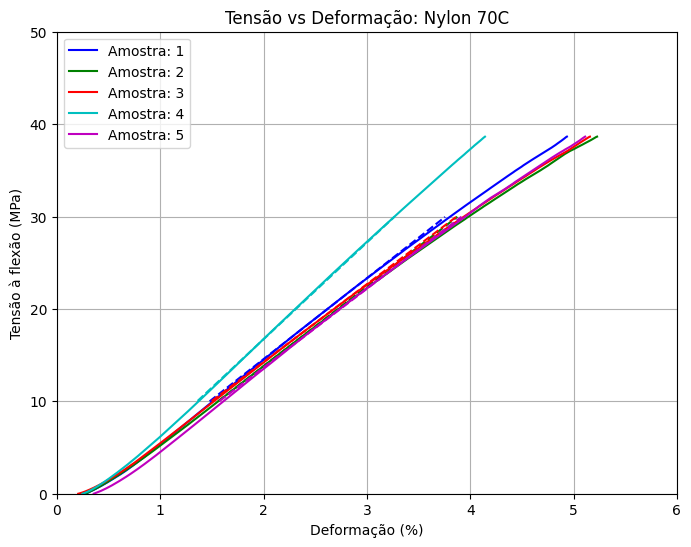

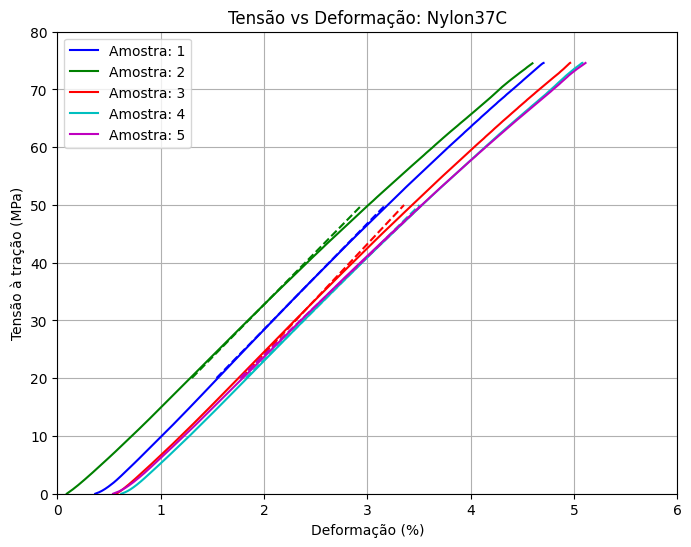

In [6]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# First figure for 'pla_fibs' data
plt.figure(figsize=(8, 6))
for i in range(len(pla_fibs)):
    deslocamento = pla_fibs[i]['Deformação (%)']
    tensao_flexao = pla_fibs[i]['Tensão à flexão (MPa)']

    # Filter data from 0 to 2.5
    '''
    mask = (deslocamento >= 0) & (deslocamento <= 2.5)
    deslocamento = deslocamento[mask]
    tensao_flexao = tensao_flexao[mask]
    '''
    
    # Plot main data
    plt.plot(deslocamento, tensao_flexao, label=f'Amostra: {i + 1}', color=colors[i])
    

    # Calculate tangent line at the middle point
    mid_idx = len(deslocamento) //2  # index for the middle point
    x0, y0 = deslocamento[mid_idx], tensao_flexao[mid_idx]
    slope, intercept = np.polyfit(deslocamento[mid_idx-1:mid_idx+2], tensao_flexao[mid_idx-1:mid_idx+2], 1)
    tangent_line = slope * (deslocamento - x0) + y0

  # Limit tangent line values between y = 40 and y = 80
    mask = (tangent_line >= 10) & (tangent_line <= 30)
    deslocamento = deslocamento[mask]
    tangent_line = tangent_line[mask]


    # Plot tangent line
    plt.plot(deslocamento, tangent_line, '--', color=colors[i])
    plt.xlim(0, 6)
    plt.ylim(0, 50)

    # Add labels, grid, title, and legend
    plt.xlabel('Deformação (%)')
    plt.ylabel('Tensão à flexão (MPa)')
    plt.title(f'Tensão vs Deformação: Nylon 70C')
    plt.grid(True)
    plt.legend()
plt.savefig(os.path.join( 'Figs', f'Nylon70C.png'))

# Second figure for 'pla_norms' data
plt.figure(figsize=(8, 6))
for i in range(len(pla_norms)):
    deslocamento = pla_norms[i]['Deformação (%)']
    tensao_flexao = pla_norms[i]['Tensão à flexão (MPa)']

    # Plot main data
    plt.plot(deslocamento, tensao_flexao, label=f'Amostra: {i + 1}', color=colors[i])
    

    # Calculate tangent line at the middle point
    mid_idx = len(deslocamento) //2
    x0, y0 = deslocamento[mid_idx], tensao_flexao[mid_idx]
    # Use numpy's polyfit to get the slope of the tangent line at the middle point
    slope, intercept = np.polyfit(deslocamento[mid_idx-1:mid_idx+2], tensao_flexao[mid_idx-1:mid_idx+2], 1)
    tangent_line = slope * (deslocamento - x0) + y0


    # Limit tangent line values between y = 40 and y = 80
    mask = (tangent_line >= 20) & (tangent_line <= 50)
    deslocamento = deslocamento[mask]
    tangent_line = tangent_line[mask]

    # Plot tangent line
    plt.plot(deslocamento, tangent_line, '--', color=colors[i])
    plt.xlim(0, 6)
    plt.ylim(0, 80)

    # Add labels, grid, title, and legend
    plt.xlabel('Deformação (%)')
    plt.ylabel('Tensão à tração (MPa)')
    plt.title(f'Tensão vs Deformação: Nylon37C')
    plt.grid(True)
    plt.legend()
plt.savefig(os.path.join('Figs', f'Nylon27.png'))


